# Report Description Classification

This notebook compares the performance of report classification with preprocessing by Spacy and NLTK, and Complement Naive Bayes and SVM models.

> This notebook is based off `notebooks/machine_learning/ski_learn_with_spacy_finetune.ipynb`

## Data Specification

This notebook was tested with data preprocessed by `ReportData` with 335 training examples. Lemmatization in preprocessing was not used as it is performed in the notebook.

Commit tested at: `a9ed0b8b4587410fd969bce6481057b205d9049e`

The results of multiple preprocessing combinations are summarized here:

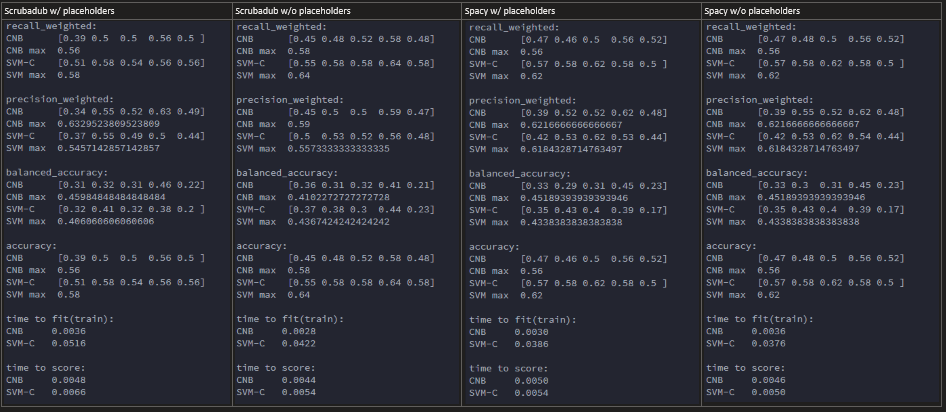
> Placeholder used is `'someone'`. w/o placeholders for scrubadub uses `'{{}}'` entities, and for spacy it uses `'*'` entities

## Setup

If running this notebook in Google Colab, upload the requested files and install the dependencies. Otherwise update the path to allow for necessary imports.

In [ ]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import files
    required_files = ['requirements.txt', 'data-processed.csv', 'report_data.py', 'report_data_d.py']
    for file in required_files:
        print(f'Upload {file}')
        files.upload()

    !pip install -r requirements.txt
else:
    from os import path
    root = path.abspath(path.join('..', '..'))
    sys.path.append(root)
    sys.path.append(path.join(root, 'preprocess'))

In [2]:
import en_core_web_lg
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight

from report_data import ReportData
from report_data_d import ColName

Download NLTK data and models

In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siepp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siepp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siepp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load Spacy NLP model trained on web documents

In [4]:
nlp = en_core_web_lg.load()

## Preprocessing

NLTK and Spacy versions of preprocessing to remove stop words and non-letter tokens, as well as perform lemmatization.

In [5]:
def spacy_tokenizer(df_sent):
    spy_txt = nlp(df_sent)
    return [
        w.lemma_ if w.lemma_ != "-PRON-" else w.text
        for w in spy_txt
        if not w.is_stop and not w.is_punct
    ]

In [6]:
def nltk_tokenizer(df_sent):
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    tokens = word_tokenize(df_sent)
    words = [word.lower() for word in tokens if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return words

Load the data

In [7]:
if IN_COLAB:
    yw_df = ReportData(out_file_path="data-processed.csv").get_processed_data()
else:
    yw_df = ReportData().get_processed_data()[[ColName.DESC, ColName.INC_T1]]

print(yw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ColName.DESC    335 non-null    object
 1   ColName.INC_T1  335 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB
None


Summarize the differences between Spacy and NLTK tokenization

In [8]:
yw_clean = yw_df[ColName.DESC]

print(
    "Spacy tokenization compared to NLTK tokenization on the same report description:\n"
)
spacy_tokens = spacy_tokenizer(yw_clean[0])
nltk_tokens = nltk_tokenizer(yw_clean[0])
print("Items in spacy_tokens but not in nltk_tokens:")
print([x for x in spacy_tokens if x not in nltk_tokens])
print()
print("Items in nltk_tokens but not in spacy_tokens:")
print([x for x in nltk_tokens if x not in spacy_tokens])

Spacy tokenization compared to NLTK tokenization on the same report description:

Items in spacy_tokens but not in nltk_tokens:
['make', 'check', 'appear', 'tell', 'want', 'call', 'ems', 'ems', 'arrive', 'assess', 'state', 'vital', 'appear', 'struggle', 'decline', 'go', 'ems']

Items in nltk_tokens but not in spacy_tokens:
['could', 'making', 'checked', 'breathing', 'appeared', 'told', 'could', 'wanted', 'called', 'em', 'em', 'arrived', 'assessed', 'stated', 'vitals', 'appeared', 'struggling', 'declined', 'going', 'em']


This notebook focuses on Multi-label classification on the primary incident type column, so we use LabelEncoder to encode the incident types

In [9]:
encoder = LabelEncoder()
yw_txt_cats = encoder.fit_transform(yw_df[ColName.INC_T1])

Use tf-idf with our Spacy tokenizer to vectorize the data. Note:

- We match single character alphanumeric words instead of the default minimum double character.
- We use both uni-grams and bi-grams, this gives more features and preserves some possibly important ordering. See [here](https://scikit-learn.org/stable/modules/feature_extraction.html?highlight=tfidf#common-vectorizer-usage) for an example.
- We set `min_df` to filter odd words that don't appear often. We only need to consider more common word patterns and filter out the odd words.

In [10]:
word_vec = TfidfVectorizer(
    tokenizer=spacy_tokenizer, token_pattern=r"\b\w+\b", ngram_range=(1, 2), min_df=2
)
yw_clean = word_vec.fit_transform(yw_clean)

Split data into training and test data. The `random_state` of `32` has been manually optimized for our data.

In [11]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    yw_clean, yw_txt_cats, train_size=0.75, random_state=32, shuffle=True
)

Assigns each label class a weight according to it's frequency of appearance in the dataset.

In [12]:
def count_weight(labels):
    weight_dict = {lb: 0 for lb in set(labels)}

    for label in labels:
        weight_dict[label] += 1

    return weight_dict

Compute sample weights for each example.

In [13]:
weight_train = compute_sample_weight(count_weight(y_train_set), y_train_set)
weight_test = compute_sample_weight(count_weight(y_test_set), y_test_set)

## Training

In [14]:
cnb = ComplementNB()
cnb.fit(X_train_set, y_train_set)

svm = SVC()
svm.fit(X_train_set, y_train_set, sample_weight=weight_train)

SVC()

In [15]:
predicted_test = cnb.predict(X_test_set)
predicted_train = cnb.predict(X_train_set)
test_score = accuracy_score(y_test_set, predicted_test, sample_weight=weight_test)
train_score = accuracy_score(y_train_set, predicted_train, sample_weight=weight_train)
test_balance = balanced_accuracy_score(
    y_test_set, predicted_test, sample_weight=weight_test
)
train_balance = balanced_accuracy_score(
    y_train_set, predicted_train, sample_weight=weight_train
)

print("Complement NB test accuracy score is: {:.2%} \n".format(test_score))
print("Complement NB train accuracy score is: {:.2%} \n".format(train_score))
print("Complement NB test balance accuracy score is: {:.2%} \n".format(test_balance))
print("Complement NB train balance accuracy score is: {:.2%} \n".format(train_balance))

Complement NB test accuracy score is: 93.77% 

Complement NB train accuracy score is: 96.67% 

Complement NB test balance accuracy score is: 35.67% 

Complement NB train balance accuracy score is: 85.62% 



In [16]:
predicted_test = svm.predict(X_test_set)
predicted_train = svm.predict(X_train_set)
test_score = accuracy_score(y_test_set, predicted_test, sample_weight=weight_test)
train_score = accuracy_score(y_train_set, predicted_train, sample_weight=weight_train)
test_balance = balanced_accuracy_score(
    y_test_set, predicted_test, sample_weight=weight_test
)
train_balance = balanced_accuracy_score(
    y_train_set, predicted_train, sample_weight=weight_train
)

print("SVM-C test accuracy score is :{:.2%} \n".format(test_score))
print("SVM-C train accuracy score is :{:.2%} \n".format(train_score))
print("SVM-C test balance accuracy score is :{:.2%} \n".format(test_balance))
print("SVM-C train balance accuracy score is :{:.2%} \n".format(train_balance))

SVM-C test accuracy score is :93.81% 

SVM-C train accuracy score is :99.80% 

SVM-C test balance accuracy score is :18.69% 

SVM-C train balance accuracy score is :83.05% 



Text(0.5, 1.0, 'Complement NB confusion matrix on train set with normalization')

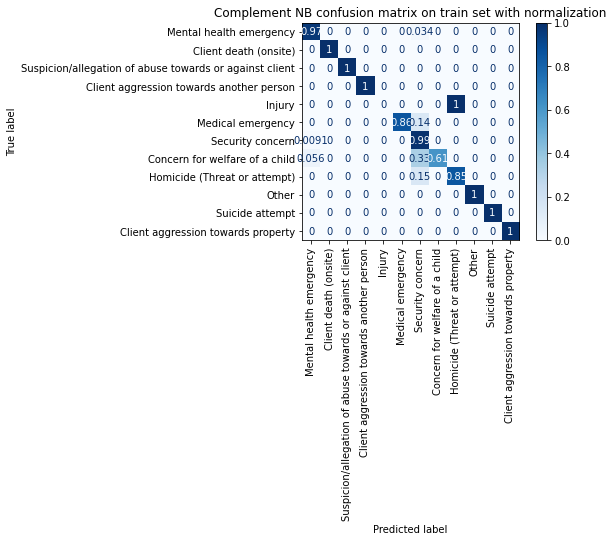

In [17]:
true_train = encoder.inverse_transform(y_train_set)
train_class = set(true_train)
disp = plot_confusion_matrix(
    cnb,
    X_train_set,
    y_train_set,
    sample_weight=weight_train,
    normalize="true",
    display_labels=train_class,
    cmap=plt.cm.Blues,
    xticks_rotation="vertical",
)
title = "Complement NB confusion matrix on train set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'Complement NB confusion matrix on test set with normalization')

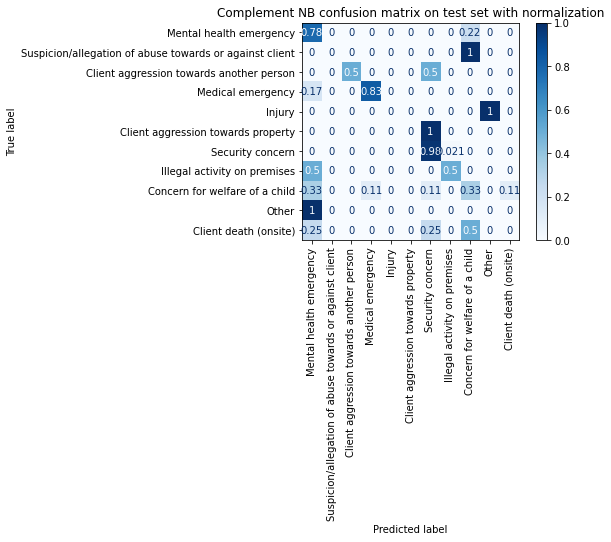

In [18]:
true_test = encoder.inverse_transform(y_test_set)
test_class = set(true_test)
disp = plot_confusion_matrix(
    cnb,
    X_test_set,
    y_test_set,
    sample_weight=weight_test,
    normalize="true",
    display_labels=test_class,
    cmap=plt.cm.Blues,
    xticks_rotation="vertical",
)
title = "Complement NB confusion matrix on test set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'SVM-C confusion matrix on train set with normalization')

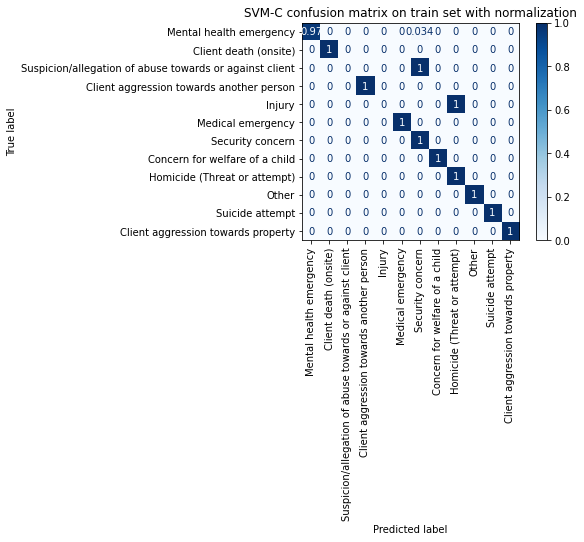

In [19]:
disp = plot_confusion_matrix(
    svm,
    X_train_set,
    y_train_set,
    sample_weight=weight_train,
    normalize="true",
    display_labels=train_class,
    cmap=plt.cm.Blues,
    xticks_rotation="vertical",
)
title = "SVM-C confusion matrix on train set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'SVM-C confusion matrix on test set with normalization')

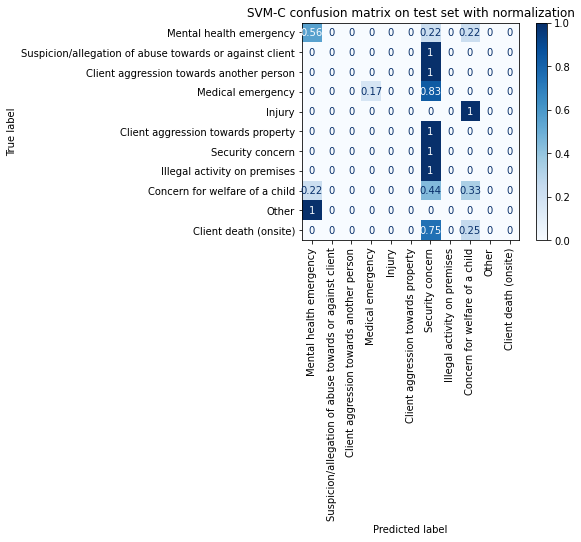

In [20]:
disp = plot_confusion_matrix(
    svm,
    X_test_set,
    y_test_set,
    sample_weight=weight_test,
    normalize="true",
    display_labels=test_class,
    cmap=plt.cm.Blues,
    xticks_rotation="vertical",
)
title = "SVM-C confusion matrix on test set with normalization"
disp.ax_.set_title(title)

In [21]:
predicted_train = encoder.inverse_transform(cnb.predict(X_train_set))
print("Complement NB train set classification report\n")
print(
    classification_report(
        true_train,
        predicted_train,
        sample_weight=weight_train,
        labels=encoder.classes_,
        target_names=encoder.classes_,
    )
)

Complement NB train set classification report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.86      0.97      0.91     841.0
                     Client aggression towards property       1.00      1.00      1.00       4.0
                                  Client death (onsite)       1.00      1.00      1.00       1.0
                         Concern for welfare of a child       1.00      1.00      1.00      81.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                           Illegal activity on premises       0.00      0.00      0.00       0.0
                                                 Injury       1.00      0.86      0.92      49.0
                                      Medical emergency       0.97      0.99      0.98   12100.0
                                Mental health emergency       1.00      0.61   

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
predicted_test = encoder.inverse_transform(cnb.predict(X_test_set))
print("Complement NB test set classification report\n")
print(
    classification_report(
        true_test,
        predicted_test,
        sample_weight=weight_test,
        labels=encoder.classes_,
        target_names=encoder.classes_,
    )
)

Complement NB test set classification report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.61      0.78      0.68      81.0
                     Client aggression towards property       0.00      0.00      0.00       1.0
                                  Client death (onsite)       1.00      0.50      0.67       4.0
                         Concern for welfare of a child       0.77      0.83      0.80      36.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                           Illegal activity on premises       0.00      0.00      0.00       1.0
                                                 Injury       0.00      0.00      0.00       4.0
                                      Medical emergency       0.99      0.98      0.98    2209.0
                                Mental health emergency       0.04      0.50    

In [23]:
predicted_train = encoder.inverse_transform(svm.predict(X_train_set))
print("SVM-C model train set classification report\n")
print(
    classification_report(
        true_train,
        predicted_train,
        sample_weight=weight_train,
        labels=encoder.classes_,
        target_names=encoder.classes_,
    )
)

SVM-C model train set classification report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       1.00      0.97      0.98     841.0
                     Client aggression towards property       1.00      1.00      1.00       4.0
                                  Client death (onsite)       0.00      0.00      0.00       1.0
                         Concern for welfare of a child       1.00      1.00      1.00      81.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       1.0
                           Illegal activity on premises       0.00      0.00      0.00       0.0
                                                 Injury       1.00      1.00      1.00      49.0
                                      Medical emergency       1.00      1.00      1.00   12100.0
                                Mental health emergency       1.00      1.00     

In [24]:
predicted_test = encoder.inverse_transform(svm.predict(X_test_set))

print("SVM-C test set classification report\n")
print(
    classification_report(
        true_test,
        predicted_test,
        sample_weight=weight_test,
        labels=encoder.classes_,
        target_names=encoder.classes_,
    )
)

SVM-C test set classification report

                                                         precision    recall  f1-score   support

               Client aggression towards another person       0.70      0.56      0.62      81.0
                     Client aggression towards property       0.00      0.00      0.00       1.0
                                  Client death (onsite)       0.00      0.00      0.00       4.0
                         Concern for welfare of a child       1.00      0.17      0.29      36.0
                           Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                           Illegal activity on premises       0.00      0.00      0.00       1.0
                                                 Injury       0.00      0.00      0.00       4.0
                                      Medical emergency       0.95      1.00      0.98    2209.0
                                Mental health emergency       0.00      0.00      0.00  

Detailed parameter fine tuning based on balanced accuracy and accuracy score on SVC.

In [25]:
svc_params_list = {
    "C": np.linspace(3, 0, num=9, endpoint=False),
    "kernel": ["sigmoid"],  # ["linear", "poly", "sigmoid"],
    "gamma": ["scale"],  # ["scale", "auto"],
    "decision_function_shape": [
        "ovo"
    ],  # Multi-class is always handled with one-vs-one # ["ovo", "ovr"],
    "class_weight": ["balanced"],  # ["balanced", None],
}

In [26]:
cv = GridSearchCV(svm, param_grid=svc_params_list, refit=False)
cv.fit(X_train_set, y_train_set)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([3.        , 2.66666667, 2.33333333, 2.        , 1.66666667,
       1.33333333, 1.        , 0.66666667, 0.33333333]),
                         'class_weight': ['balanced'],
                         'decision_function_shape': ['ovo'], 'gamma': ['scale'],
                         'kernel': ['sigmoid']},
             refit=False)

In [27]:
cv.best_params_

{'C': 2.6666666666666665,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'sigmoid'}

In [28]:
scoring = ["recall_weighted", "precision_weighted", "balanced_accuracy", "accuracy"]
fit_params = {"sample_weight": weight_train}

svm_op = SVC(**cv.best_params_)
svm_op.fit(X_train_set, y_train_set, sample_weight=weight_train)
cv_s = cross_validate(
    svm_op,  # change to svm variable to see differences from fine tuning
    X_train_set,
    y_train_set,
    scoring=scoring,
    fit_params=fit_params,
)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
cv_nb = GridSearchCV(cnb, param_grid={"alpha": np.linspace(3, 0, num=9)}, refit=False)
cv_nb.fit(X_train_set, y_train_set)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in 

GridSearchCV(estimator=ComplementNB(),
             param_grid={'alpha': array([3.   , 2.625, 2.25 , 1.875, 1.5  , 1.125, 0.75 , 0.375, 0.   ])},
             refit=False)

In [30]:
cv_nb.best_params_

{'alpha': 0.75}

In [31]:
cnb_op = ComplementNB(**cv_nb.best_params_)
cnb_op.fit(X_train_set, y_train_set, sample_weight=weight_train)
cv_b = cross_validate(
    cnb_op, X_train_set, y_train_set, scoring=scoring, fit_params=fit_params,
)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

In [32]:
def compare_score(score: str):
    np.set_printoptions(precision=2)
    print(f"{score}:")
    cnb = cv_b[f"test_{score}"]
    print("CNB\t", cnb)
    print("CNB max\t", cnb.max())
    svm = cv_s[f"test_{score}"]
    print("SVM-C\t", svm)
    print("SVM max\t", svm.max())


for score in scoring:
    compare_score(score)
    print()

print(
    "time to fit(train):\nCNB\t{:.4f}\nSVM-C\t{:.4f}\n".format(
        np.average(cv_b["fit_time"]), np.average(cv_s["fit_time"])
    )
)
print(
    "time to score:\nCNB\t{:.4f}\nSVM-C\t{:.4f}\n".format(
        np.average(cv_b["score_time"]), np.average(cv_s["score_time"])
    )
)

recall_weighted:
CNB	 [0.47 0.48 0.5  0.56 0.52]
CNB max	 0.56
SVM-C	 [0.57 0.58 0.62 0.58 0.5 ]
SVM max	 0.62

precision_weighted:
CNB	 [0.39 0.55 0.52 0.62 0.48]
CNB max	 0.6216666666666667
SVM-C	 [0.42 0.53 0.62 0.54 0.44]
SVM max	 0.6184328714763497

balanced_accuracy:
CNB	 [0.33 0.3  0.31 0.45 0.23]
CNB max	 0.45189393939393946
SVM-C	 [0.35 0.43 0.4  0.39 0.17]
SVM max	 0.4338383838383838

accuracy:
CNB	 [0.47 0.48 0.5  0.56 0.52]
CNB max	 0.56
SVM-C	 [0.57 0.58 0.62 0.58 0.5 ]
SVM max	 0.62

time to fit(train):
CNB	0.0030
SVM-C	0.0428

time to score:
CNB	0.0084
SVM-C	0.0056

